In [2]:
pip install --upgrade pyod


[notice] A new release of pip available: 22.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install combo


[notice] A new release of pip available: 22.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from pandas import json_normalize
import json
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import ruptures as rpt
from collections import Counter

In [5]:
data_path = "MSL"

In [6]:
# No requirement to create multi index for datasets like SWAT

In [7]:
train_data = np.load(data_path + "/MSL_train.npy")
# train_data_label = np.load(data_path + "/SWAT_train_label_mix.npy")
test_data = np.load(data_path+"/MSL_test.npy")
test_data_label = np.load(data_path + '/MSL_test_label.npy').astype(int)

In [8]:
train_data_label = test_data_label[0:len(train_data)]

In [9]:
train_data_label

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
# train_data_label = pd.DataFrame(labelled_data.iloc[0:train_size,29].values.astype(int), columns=['isDeviceWorking'])
# test_data_label = pd.DataFrame(labelled_data.iloc[train_size:len(labelled_data),29].values.astype(int), columns=['isDeviceWorking'])
len(train_data)

58317

In [11]:
len(test_data)

73729

In [12]:
len(test_data_label)

73729

In [13]:
# LSTM is a type of RNN - we need sequences that act as an input to the LSTM. Chunks of timestamps are used as sequences

# Create sequences for each device. Take timestamps for each deviceId and form sequences taking 10 time steps at a time.
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [],[]
    for i in range(len(X) - time_steps):
#         Take the value of current time step (x) and do a bit of indexing. 
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])

    return np.array(Xs), np.array(ys)


In [14]:
TIME_STEPS = 100

In [15]:
# Convert train dataset into sequences
# Start with 5 time steps as history.

# TIME_STEPS = 5

X_train, y_train = create_dataset(train_data, train_data_label, TIME_STEPS)
X_test, y_test = create_dataset(test_data,test_data_label,TIME_STEPS)

In [16]:
len(y_test)

73629

In [17]:
# The shape of the created sequence dataset: 
# it's a 3-D tensor which contains the timeseries, time step (history), and number of features
X_train.shape

(58217, 100, 55)

In [18]:
y_train.shape

(58217,)

In [19]:
# The sequences form the input to LSTM Autoencoder
# Idea behind this is to train a model based on our data, measure the error post training. 
# If the error is above a threshold, the model cannot reconstruct the data, indicative of an anomaly (predictive)

In [20]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers
from keras.datasets import imdb
from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

In [21]:
model = Sequential()
# Add an LSTM Layer with 64 units
model.add(LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))

# Add a dropout layer for regularization
model.add(Dropout(rate = 0.2))

# add a repeat layer
# This is important because we need to return the sequence for the next LSTM layer to work with.
model.add(RepeatVector(n=X_train.shape[1]))

# Add another LSTM Layer
model.add(LSTM(
    units=64, 
    return_sequences=True
))
model.add(Dropout(rate = 0.2))

# Output time distributed, fully connected layer 
# return same amount of data that was given as input, 
# that is reconstructed after learning the most important features of our data

model.add(TimeDistributed(Dense(
#     Number of features that we have is the number of dimensions of our predictions column, which is y_train.shape[1]
#     units = X_train.shape[2]   
    units = 1
)))

model.compile(loss='mae', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                30720     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 100, 64)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 time_distributed (TimeDistr  (None, 100, 1)           65        
 ibuted)                                                

In [22]:
# Train the model
# Important: In time series data, do not shuffle the data because data is history dependent
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle = False
)

Epoch 1/10
1638/1638 [==============================] - 121s 71ms/step - loss: 0.1393 - val_loss: 0.0407
Epoch 2/10
1638/1638 [==============================] - 117s 72ms/step - loss: 0.1353 - val_loss: 0.0315
Epoch 3/10
1638/1638 [==============================] - 122s 75ms/step - loss: 0.1336 - val_loss: 0.0311
Epoch 4/10
1638/1638 [==============================] - 112s 69ms/step - loss: 0.1329 - val_loss: 0.0311
Epoch 5/10
1638/1638 [==============================] - 132s 81ms/step - loss: 0.1325 - val_loss: 0.0311
Epoch 6/10
1638/1638 [==============================] - 129s 79ms/step - loss: 0.1323 - val_loss: 0.0311
Epoch 7/10
1638/1638 [==============================] - 129s 79ms/step - loss: 0.1322 - val_loss: 0.0311
Epoch 8/10
1638/1638 [==============================] - 131s 80ms/step - loss: 0.1322 - val_loss: 0.0312
Epoch 9/10
1638/1638 [==============================] - 134s 82ms/step - loss: 0.1322 - val_loss: 0.0312
Epoch 10/10
1638/1638 [==============================] 

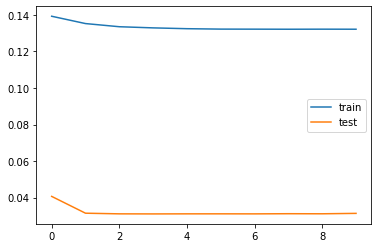

In [23]:
# As you can see, validation loss decreases steadily in above output (indicates some hints of possible learning)

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend();

In [24]:
# Take the predictions for the training data that we have
X_train_pred = model.predict(X_train)

1820/1820 [==============================] - 50s 27ms/step


In [25]:
X_train_pred.shape

(58217, 100, 1)

In [26]:
X_train_pred_reshaped = X_train_pred[:,0,:]

In [27]:
X_train_pred_reshaped.shape

(58217, 1)

In [28]:
y_train.shape

(58217,)

In [29]:
y_train_reshape = y_train.reshape((58217, 1))

In [30]:
y_train_reshape.shape

(58217, 1)

C:\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

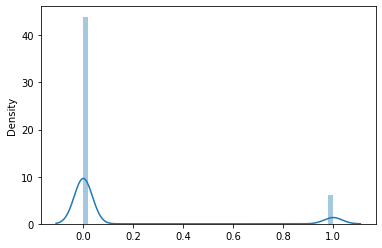

In [31]:
# take mae on training set and calculate error

import seaborn as sns
train_mae_loss = np.mean(np.abs(X_train_pred_reshaped - y_train_reshape), axis =1)
sns.distplot(train_mae_loss, bins=50,kde=True)
# This gives us an idea of what to set as a threshold (which is a hyperparameter)

In [32]:
y_test.shape

(73629,)

In [33]:
# Do the same for test set
X_test_pred = model.predict(X_test)
X_test_pred_reshaped = X_test_pred[:,0,:]
y_test_reshape = y_test.reshape((73629, 1))
test_mae_loss = np.mean(np.abs(X_test_pred_reshaped - y_test_reshape), axis =1)

2301/2301 [==============================] - 62s 27ms/step


In [34]:
len(X_test_pred)

73629

In [35]:
X_test_pred_reshaped.shape

(73629, 1)

C:\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

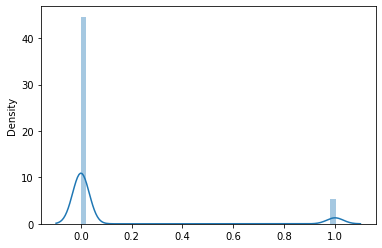

In [36]:
sns.distplot(test_mae_loss, bins=50,kde=True)

In [37]:
test_data_label

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
# Dynamic thresholding: εij = μ(eij ) + zσ(eij )
# Find mean and SD of errors
# Find suitable z to calculate threshold. 

# Find mean with no axis, i.e.:  to compute the mean of the flattened array
mean = np.mean(np.abs(X_train_pred_reshaped - y_train_reshape.astype('float32')))
standard_deviation = np.std(np.abs(X_train_pred_reshaped - y_train_reshape.astype('float32')))

# Dynamic Threshold
# Here, the z value is dynamic
# Values for z depend on context, usually between two and ten to work well based on our experimental results.

# Dynamic Threshold with z = 1-.75
dynamic_threshold = (mean + (0.75*standard_deviation))


In [39]:
dynamic_threshold = 1.00

In [40]:
# Perform thresholding
THRESHOLD = 0.75

test_score_df = pd.DataFrame()
# test_score_df = pd.DataFrame(index=test_data_label[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = dynamic_threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
# test_score_df['isDeviceWorking'] = test_data_label.isDeviceWorking
test_score_df['actual_labels'] = y_test

In [41]:
# test_score_df.loc[test_score_df['anomaly'] == False]
test_score_df

,loss,threshold,anomaly,actual_labels
0,0.000304,1.0,False,0
1,0.000304,1.0,False,0
2,0.000304,1.0,False,0
3,0.000304,1.0,False,0
4,0.000304,1.0,False,0
...,...,...,...,...
73624,0.000304,1.0,False,0
73625,0.000304,1.0,False,0
73626,0.000304,1.0,False,0
73627,0.000304,1.0,False,0


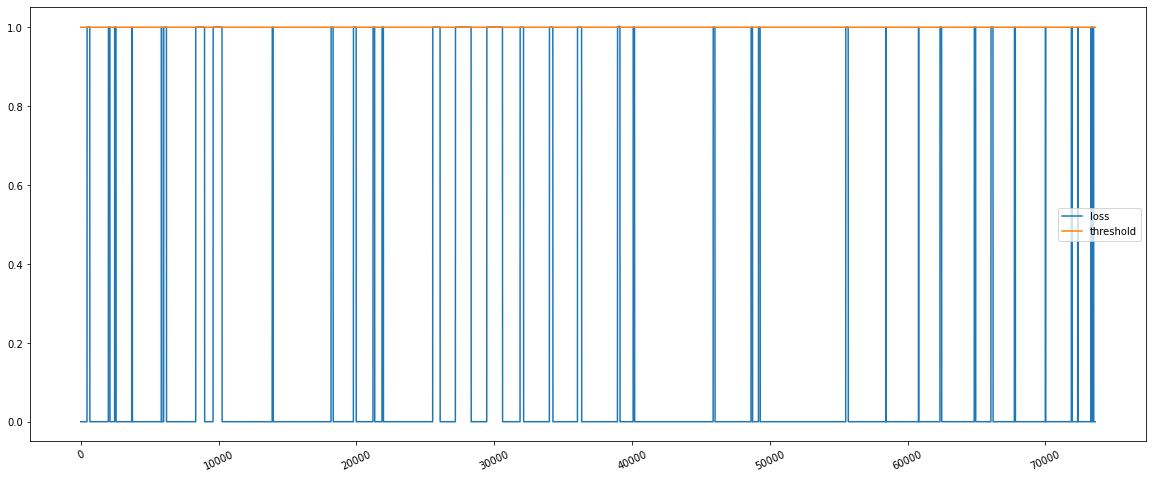

In [42]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)
plt.plot(test_score_df.index, test_score_df.loss, label = 'loss')
plt.plot(test_score_df.index,test_score_df.threshold, label = 'threshold')
# plt.plot(test_score_df.index,test_score_df.actual_labels, label = 'Actual Value')
plt.xticks(rotation=25)
plt.legend()

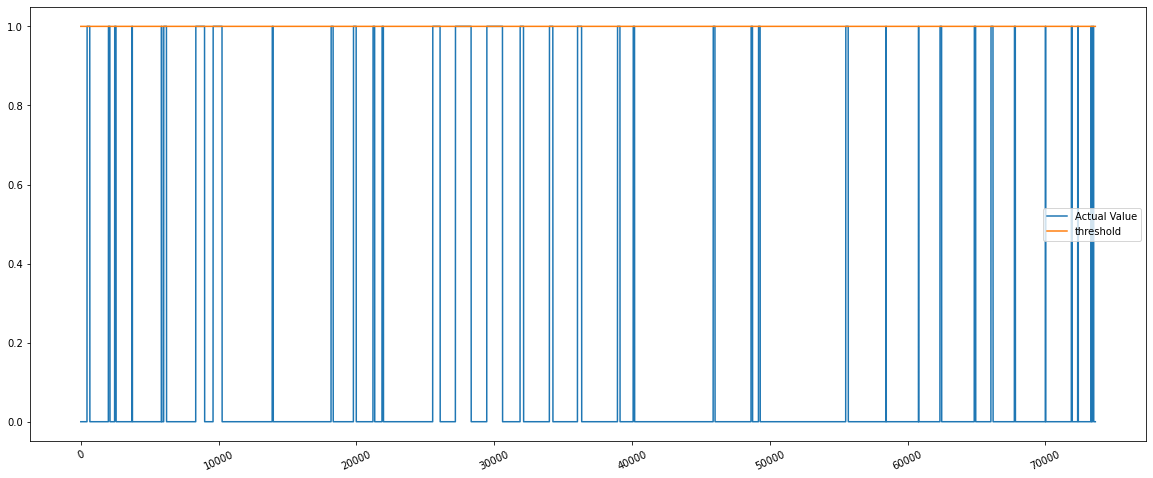

In [43]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)
# plt.plot(test_score_df.index, test_score_df.loss, label = 'loss')
plt.plot(test_score_df.index,test_score_df.actual_labels, label = 'Actual Value')
plt.plot(test_score_df.index,test_score_df.threshold, label = 'threshold')
plt.xticks(rotation=25)
plt.legend()

In [44]:
actual_anomalies = test_score_df[test_score_df.actual_labels == 1.0]
actual_anomalies

,loss,threshold,anomaly,actual_labels
450,1.000304,1.0,True,1
451,1.000304,1.0,True,1
452,1.000304,1.0,True,1
453,1.000304,1.0,True,1
454,1.000304,1.0,True,1
...,...,...,...,...
73499,1.000304,1.0,True,1
73500,1.000304,1.0,True,1
73501,1.000304,1.0,True,1
73502,1.000304,1.0,True,1


In [45]:
detected_anomalies = test_score_df[test_score_df.anomaly == True]
detected_anomalies

,loss,threshold,anomaly,actual_labels
450,1.000304,1.0,True,1
451,1.000304,1.0,True,1
452,1.000304,1.0,True,1
453,1.000304,1.0,True,1
454,1.000304,1.0,True,1
...,...,...,...,...
73499,1.000304,1.0,True,1
73500,1.000304,1.0,True,1
73501,1.000304,1.0,True,1
73502,1.000304,1.0,True,1


In [46]:
 from sklearn.metrics import precision_recall_fscore_support

In [47]:
len(test_score_df)

73629

In [48]:
X_test_pred_reshaped

array([[-0.00030439],
       [-0.00030439],
       [-0.00030439],
       ...,
       [-0.00030439],
       [-0.00030439],
       [-0.00030439]], dtype=float32)

In [53]:
len(y_test[50:73629])

73579

In [51]:
len(test_score_df.loc[0:73578].anomaly)

73529

In [56]:
precision_recall_fscore_support(y_test[50:73629], test_score_df.loc[0:73578].anomaly, average='macro')

(0.8821679344803408, 0.8821679344803408, 0.8821679344803408, None)